# TS diagrams at boundaries

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import gsw
import xarray as xr

%matplotlib inline

#### Parameters

In [21]:
# domain dimensions:
imin, imax = 1139, 2179
jmin, jmax = 159, 799

# Rimwidths:
rimwidthN  = 10
rimwidthS  = 10
rimwidthW  = 10
rimwidthE  = 20

# Boundary coordinates: (i1,i2,j1,j2)
bdy_NCB = (1600,imax,jmax,jmax) # Northern Canada Basin
bdy_WCB = (imax,imax,391,jmax)  # Western Canada Basin
bdy_LS  = (imin,imin,449,674)   # Labrador Sea
bdy_HB  = (1189,1474,291,291)   # Hudson Bay

In [3]:
# Colors
land_color = '#a9a7a2'
color_sBB  = '#cc0e1d'
color_sGR  = '#ffb7aa'
light_gray = '#b1b1b1'

#### Files

In [4]:
mesh         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = np.array(mesh.variables['nav_lon'])
mesh_lat     = np.array(mesh.variables['nav_lat'])
mesh_bathy   = np.array(mesh.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
depths       = np.array(mesh.variables['nav_lev'])

Pb observations:

In [6]:
folder= '/ocean/brogalla/GEOTRACES/data/'

# Data from the GEOTRACES 2021 Intermediate Data Product

#------------------------- North Atlantic Ocean:--------------------------------------------------------------
df_NA = nc.Dataset(f'{folder}IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_pZVh4suO.nc')
NA_lons       = np.array(df_NA.variables['longitude'])
NA_lats       = np.array(df_NA.variables['latitude'])
NA_pressure   = np.array(df_NA.variables['var1']) # pressure from CTD sensor in dbar
NA_depths     = np.array(df_NA.variables['var2']) # depth below sea surface calculated from pressure
NA_temp_C     = np.array(df_NA.variables['var3']) # temperature from CTD sensor in ITS-90 convention
NA_sal_pss78  = np.array(df_NA.variables['var4']) # practical salinity from CTD sensor in PSS-1978 scale
NA_dPb_pmolkg = np.array(df_NA.variables['var9']) # concentration of dissolved Pb in pmol/kg 

#---- unit conversions: ----
# CTD sensor pressure --> sea pressure (absolute pressure minus 10.1325 dbar); mask pressures less than atmospheric pressure
NA_sea_pressure = np.ma.masked_where(NA_pressure < -1e8, NA_pressure)
# practical salinity --> absolute salinity (g/kg)
NA_lons_tile  = np.tile(NA_lons, (301,1)).transpose()
NA_lats_tile  = np.tile(NA_lats, (301,1)).transpose()
NA_sal_abs      = gsw.conversions.SA_from_SP(NA_sal_pss78, NA_sea_pressure, NA_lons_tile, NA_lats_tile)
# calculate density: uses in situ temperature, absolute salinity, sea pressure 
NA_density      = gsw.density.rho_t_exact(NA_sal_abs, NA_temp_C, NA_sea_pressure) # kg/m3
# dPb in pmol/kg --> pmol/L
NA_dPb_pmolL    = np.ma.masked_where(NA_dPb_pmolkg < 0, NA_dPb_pmolkg*NA_density*1e-3)

#------------------------- Arctic Ocean:----------------------------------------------------------------------
df_AO         = nc.Dataset(f'{folder}IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_iVeYJS4U.nc')
AO_lons       = np.array(df_AO.variables['longitude'])
AO_lats       = np.array(df_AO.variables['latitude'])
AO_pressure   = np.array(df_AO.variables['var1']) # pressure from CTD sensor in dbar
AO_depths     = np.array(df_AO.variables['var2']) # depth below sea surface calculated from pressure
AO_temp_C     = np.array(df_AO.variables['var3']) # temperature from CTD sensor in ITS-90 convention
AO_sal_pss78  = np.array(df_AO.variables['var4']) # practical salinity from CTD sensor in PSS-1978 scale
AO_dPb_pmolkg = np.array(df_AO.variables['var9']) # concentration of dissolved Pb in pmol/kg 
# AO_sal_pss78  = np.array(df_AO.variables['var5']) # practical salinity from bottle sample in PSS-1978 scale

#---- unit conversions: ----
# CTD sensor pressure --> sea pressure (absolute pressure minus 10.1325 dbar); mask pressures less than atmospheric pressure
AO_sea_pressure = np.ma.masked_where(AO_pressure < -1e8, AO_pressure)
# practical salinity --> absolute salinity (g/kg)
AO_lons_tile    = np.tile(AO_lons, (345,1)).transpose()
AO_lats_tile    = np.tile(AO_lats, (345,1)).transpose()
AO_sal_abs      = gsw.conversions.SA_from_SP(AO_sal_pss78, AO_sea_pressure, AO_lons_tile, AO_lats_tile)
# calculate density: uses in situ temperature, absolute salinity, sea pressure 
AO_density      = gsw.density.rho_t_exact(AO_sal_abs, AO_temp_C, AO_sea_pressure) # kg/m3
# dPb in pmol/kg --> pmol/L
AO_dPb_pmolL    = np.ma.masked_where(AO_dPb_pmolkg < 0, AO_dPb_pmolkg*AO_density*1e-3)
AO_depths       = np.ma.masked_where(AO_depths < 0, AO_depths)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/gsw/_wrapped_ufuncs.py:3071: RuntimeWarning: invalid value encountered in rho_t_exact
  return _gsw_ufuncs.rho_t_exact(SA, t, p)


In [7]:
Pb_IDP = xr.open_dataset(f'{folder}IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_6JQGakpX.nc')
Sbdy_lons       = Pb_IDP['longitude'].values
Sbdy_lats       = Pb_IDP['latitude'].values
Sbdy_pressure   = Pb_IDP['var1'].values # pressure from CTD sensor in dbar
Sbdy_depths     = Pb_IDP['var2'].values # depth below sea surface calculated from pressure
Sbdy_temp_C     = Pb_IDP['var3'].values # temperature from CTD sensor in ITS-90 convention
Sbdy_sal_pss78  = Pb_IDP['var4'].values # practical salinity from CTD sensor in PSS-1978 scale
Sbdy_dPb_pmolkg = Pb_IDP['var9'].values # concentration of dissolved Pb in pmol/kg 
Sbdy_dPb_pmolkg_qc = Pb_IDP['var9_qc'].values # flag_meanings :[48 49 50 51 52]
# no_quality_control, good_value, probably_good_value, probably_bad_value, bad_value
Sbdy_dPb_pmolkg = np.ma.masked_where(Sbdy_dPb_pmolkg_qc > 50, Sbdy_dPb_pmolkg) # mask probably bad values

# Unit conversions
Sbdy_sea_pressure = np.ma.masked_where(Sbdy_pressure < -1e8, Sbdy_pressure)
# practical salinity --> absolute salinity (g/kg)
Sbdy_lons_tile    = np.tile(Sbdy_lons, (268,1)).transpose()
Sbdy_lats_tile    = np.tile(Sbdy_lats, (268,1)).transpose()
Sbdy_sal_abs      = gsw.conversions.SA_from_SP(Sbdy_sal_pss78, Sbdy_sea_pressure, Sbdy_lons_tile, Sbdy_lats_tile)
# calculate density: uses in situ temperature, absolute salinity, sea pressure 
Sbdy_density      = gsw.density.rho_t_exact(Sbdy_sal_abs, Sbdy_temp_C, Sbdy_sea_pressure) # kg/m3
# dPb in pmol/kg --> pmol/L
Sbdy_dPb_pmolL    = np.ma.masked_where(Sbdy_dPb_pmolkg < 0, Sbdy_dPb_pmolkg*Sbdy_density*1e-3)
Sbdy_depths       = np.ma.masked_where(Sbdy_depths < 0, Sbdy_depths)

#### Functions

In [57]:
def plot_density_lines(ax):
    
    density_range     = np.arange(1018,1031,0.5)
    temperature_range = np.linspace(-3,8,20)
    salinity_grid     = np.empty((len(density_range),len(temperature_range)))

    for d,density in enumerate(density_range):
        for t,temperature in enumerate(temperature_range):
            salinity_grid[d,t] = gsw.conversions.SA_from_rho(density, temperature, 0) # sea level pressure in dbar

    temperature_grid, density_grid = np.meshgrid(temperature_range, density_range)
    
    CS = ax.contour(salinity_grid, temperature_grid, density_grid, colors='#717372', levels=20, linestyles='--', linewidths=0.3, zorder=1)    
#     ax.clabel(CS, levels=[1023, 1024, 1025, 1026, 1027, 1028], fontsize=4.5, fmt='%.f', \
#           manual=[(29,-2),(30.5,-2),(31.5,-2),(32.5,-2),(33.5,-2),(35,-2)])
    
    return


In [50]:
def load_climatology(month, bdy=''):        
    # load year 2015 climatology of ANHA12 gridT file:
    df_gridT = xr.open_dataset(f'/data/brogalla/ANHA12/gridT_2015_climatology_{month}.nc')
    
    if bdy=='':
        print('Boundary not specified. Choose one of: LS, wCB, nCB')
    elif bdy=='LS':
        bdy_temp = df_gridT['votemper'].values[0,:,bdy_LS[0]:bdy_LS[0]+rimwidthS,bdy_LS[2]:bdy_LS[3]]
        bdy_sal  = df_gridT['vosaline'].values[0,:,bdy_LS[0]:bdy_LS[0]+rimwidthS,bdy_LS[2]:bdy_LS[3]]
    elif bdy=='wCB':
        bdy_temp = df_gridT['votemper'].values[0,:,bdy_WCB[0]:bdy_WCB[0]+rimwidthN,bdy_WCB[2]:bdy_WCB[3]]
        bdy_sal  = df_gridT['vosaline'].values[0,:,bdy_WCB[0]:bdy_WCB[0]+rimwidthN,bdy_WCB[2]:bdy_WCB[3]]
    elif bdy=='nCB':
        bdy_temp = df_gridT['votemper'].values[0,:,bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]+rimwidthE]
        bdy_sal  = df_gridT['vosaline'].values[0,:,bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]+rimwidthE]
    elif bdy=='HB':
        bdy_temp = df_gridT['votemper'].values[0,:,bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]+rimwidthW]
        bdy_sal  = df_gridT['vosaline'].values[0,:,bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]+rimwidthW]      
    else:
        print('Boundary name does not exist')
    
#     bdy_dens = gsw.density.sigma0(bdy_sal, bdy_temp)
#     bdy_dens[bdy_dens < 0] = 0
    return bdy_temp, bdy_sal

In [67]:
def create_LS_BC(bdy_temp, bdy_sal):
    # Pb end-members:
    BBDW_Pb   = 2e-12  # Baffin Bay deep water Pb
    AO_Pb     = 6e-12  # Arctic water Pb
    AW_Pb     = 30e-12 # Atlantic water Pb
    AOAW_Pb   = 25e-12 # Arctic-outflow Atlantic water Pb
    AW_temp   = 5.2    # Atlantic Water temperature
    BBDW_temp = 2.5    # Baffin Bay deep water temperature 
    AW_sal    = 35.2   # Atlantic Water salinity

    # Linear interpolate salinity endpoints:
    end_sal = [33.3, AW_sal]
    end_dPb = [AO_Pb, AOAW_Pb]
    dPb_BC  = np.interp(bdy_sal, end_sal, end_dPb)

    # Baffin Bay deep water:
    end_temp_BBDW = [BBDW_temp, AW_temp]
    end_dPb_BBDW  = [BBDW_Pb, AOAW_Pb]
    dPb_BC[(bdy_sal > 34.8) & (bdy_temp < AW_temp)] = np.interp(bdy_temp[(bdy_sal > 34.8) & (bdy_temp < AW_temp)], \
                                                                  end_temp_BBDW, end_dPb_BBDW)

    # Atlantic Water off Greenland:
    grid = 150 # Grid point of central BB
    boundary_sal = 35.05 # salinity of outer-edge of Atlantic Water core off Greenland
    end_sal_AW   = [boundary_sal, AW_sal]
    end_dPb_AW   = [AOAW_Pb, AW_Pb]
    dPb_BC[:,:,grid:][(bdy_sal[:,:,grid:] > boundary_sal) & (bdy_temp[:,:,grid:] > AW_temp)] =  \
        np.interp(bdy_sal[:,:,grid:][(bdy_sal[:,:,grid:] > boundary_sal) & (bdy_temp[:,:,grid:] > AW_temp)], end_sal_AW, end_dPb_AW)

    return dPb_BC

In [98]:
def create_CB_BC(bdy_temp, bdy_sal):
    # Pb end-members:
    PML_Pb   = 3e-12   # Polar Mixed Layer Pb
    ACW_Pb   = 8e-12  # Alaskan Coastal Water Pb
    wBSW_Pb  = 3e-12   # Winter Bering Sea Water Pb
    AL_Pb    = 5e-12   # Atlantic Water Pb
    CBDW_Pb  = 2e-12   # Canada Basin deep water Pb
    
    PML_sal   = 29      # Polar mixed layer salinity max
    PML_temp  = 0       # Polar mixed layer temperature
    ACW_sal   = 32.5    # ACW salinity
    ACW_temp  = 2       # ACW temperature
    wBSW_temp = 34.8    # Winter Bering Sea Water temperature
    wBSW_sal  = 32.5    # Winter Bering Sea Water salinity
    AL_temp   = 0.1     # Atlantic Water temperature min
    AL_sal    = 34.8    # Atlantic Water salinity min
    CBDW_temp = 0.0    # Canada Basin deep water temperature
    CBDW_sal  = 35.0    # Canada Basin deep water salinity
    
    # Linear interpolate endpoints between PML and ACW:
    end_temp = [PML_temp, ACW_temp]
    end_dPb = [PML_Pb, ACW_Pb]
    dPb_BC  = np.interp(bdy_temp, end_temp, end_dPb)

    # wBSW to AL
    end_sal_AL = [wBSW_sal, AL_sal]
    end_dPb_AL = [wBSW_Pb, AL_Pb]
    dPb_BC[(bdy_sal > wBSW_sal) & (bdy_sal < AL_sal)] = np.interp(bdy_sal[(bdy_sal > wBSW_sal) & (bdy_sal < AL_sal)], \
                                                                  end_sal_AL, end_dPb_AL)
    
    # AL to CBDW
    end_temp_CBDW = [CBDW_temp, AL_temp]
    end_dPb_CBDW  = [CBDW_Pb, AL_Pb]
    dPb_BC[(bdy_sal > AL_sal)] = np.interp(bdy_temp[(bdy_sal > AL_sal)], end_temp_CBDW, end_dPb_CBDW)
    
    
    return dPb_BC

#### Load files

In [99]:
# load year 2015 climatology of ANHA12 gridT file:
df_gridT = nc.Dataset('/data/brogalla/ANHA12/gridT_2015_climatology_08.nc')

LS_temp = np.array(df_gridT.variables['votemper'])[0,:,bdy_LS[0]:bdy_LS[0]+rimwidthS,bdy_LS[2]:bdy_LS[3]]
LS_sal  = np.array(df_gridT.variables['vosaline'])[0,:,bdy_LS[0]:bdy_LS[0]+rimwidthS,bdy_LS[2]:bdy_LS[3]]
LS_dens = gsw.density.sigma0(LS_sal, LS_temp)
LS_dens[BB_dens < 0] = 0
LS_depth = np.tile(depths, (225,10,1)).transpose()

#### Calculations

In [100]:
month=8

LS_T , LS_S  = load_climatology(f'{month:02}', bdy='LS')
wCB_T, wCB_S = load_climatology(f'{month:02}', bdy='wCB')
nCB_T, nCB_S = load_climatology(f'{month:02}', bdy='nCB')
HB_T , HB_S  = load_climatology(f'{month:02}', bdy='HB')

dPb_LS  = create_LS_BC(LS_T , LS_S)
dPb_wCB = create_CB_BC(wCB_T, wCB_S)
dPb_nCB = create_CB_BC(nCB_T, nCB_S)
dPb_HB  = create_CB_BC(HB_T, HB_S)

#### Figures

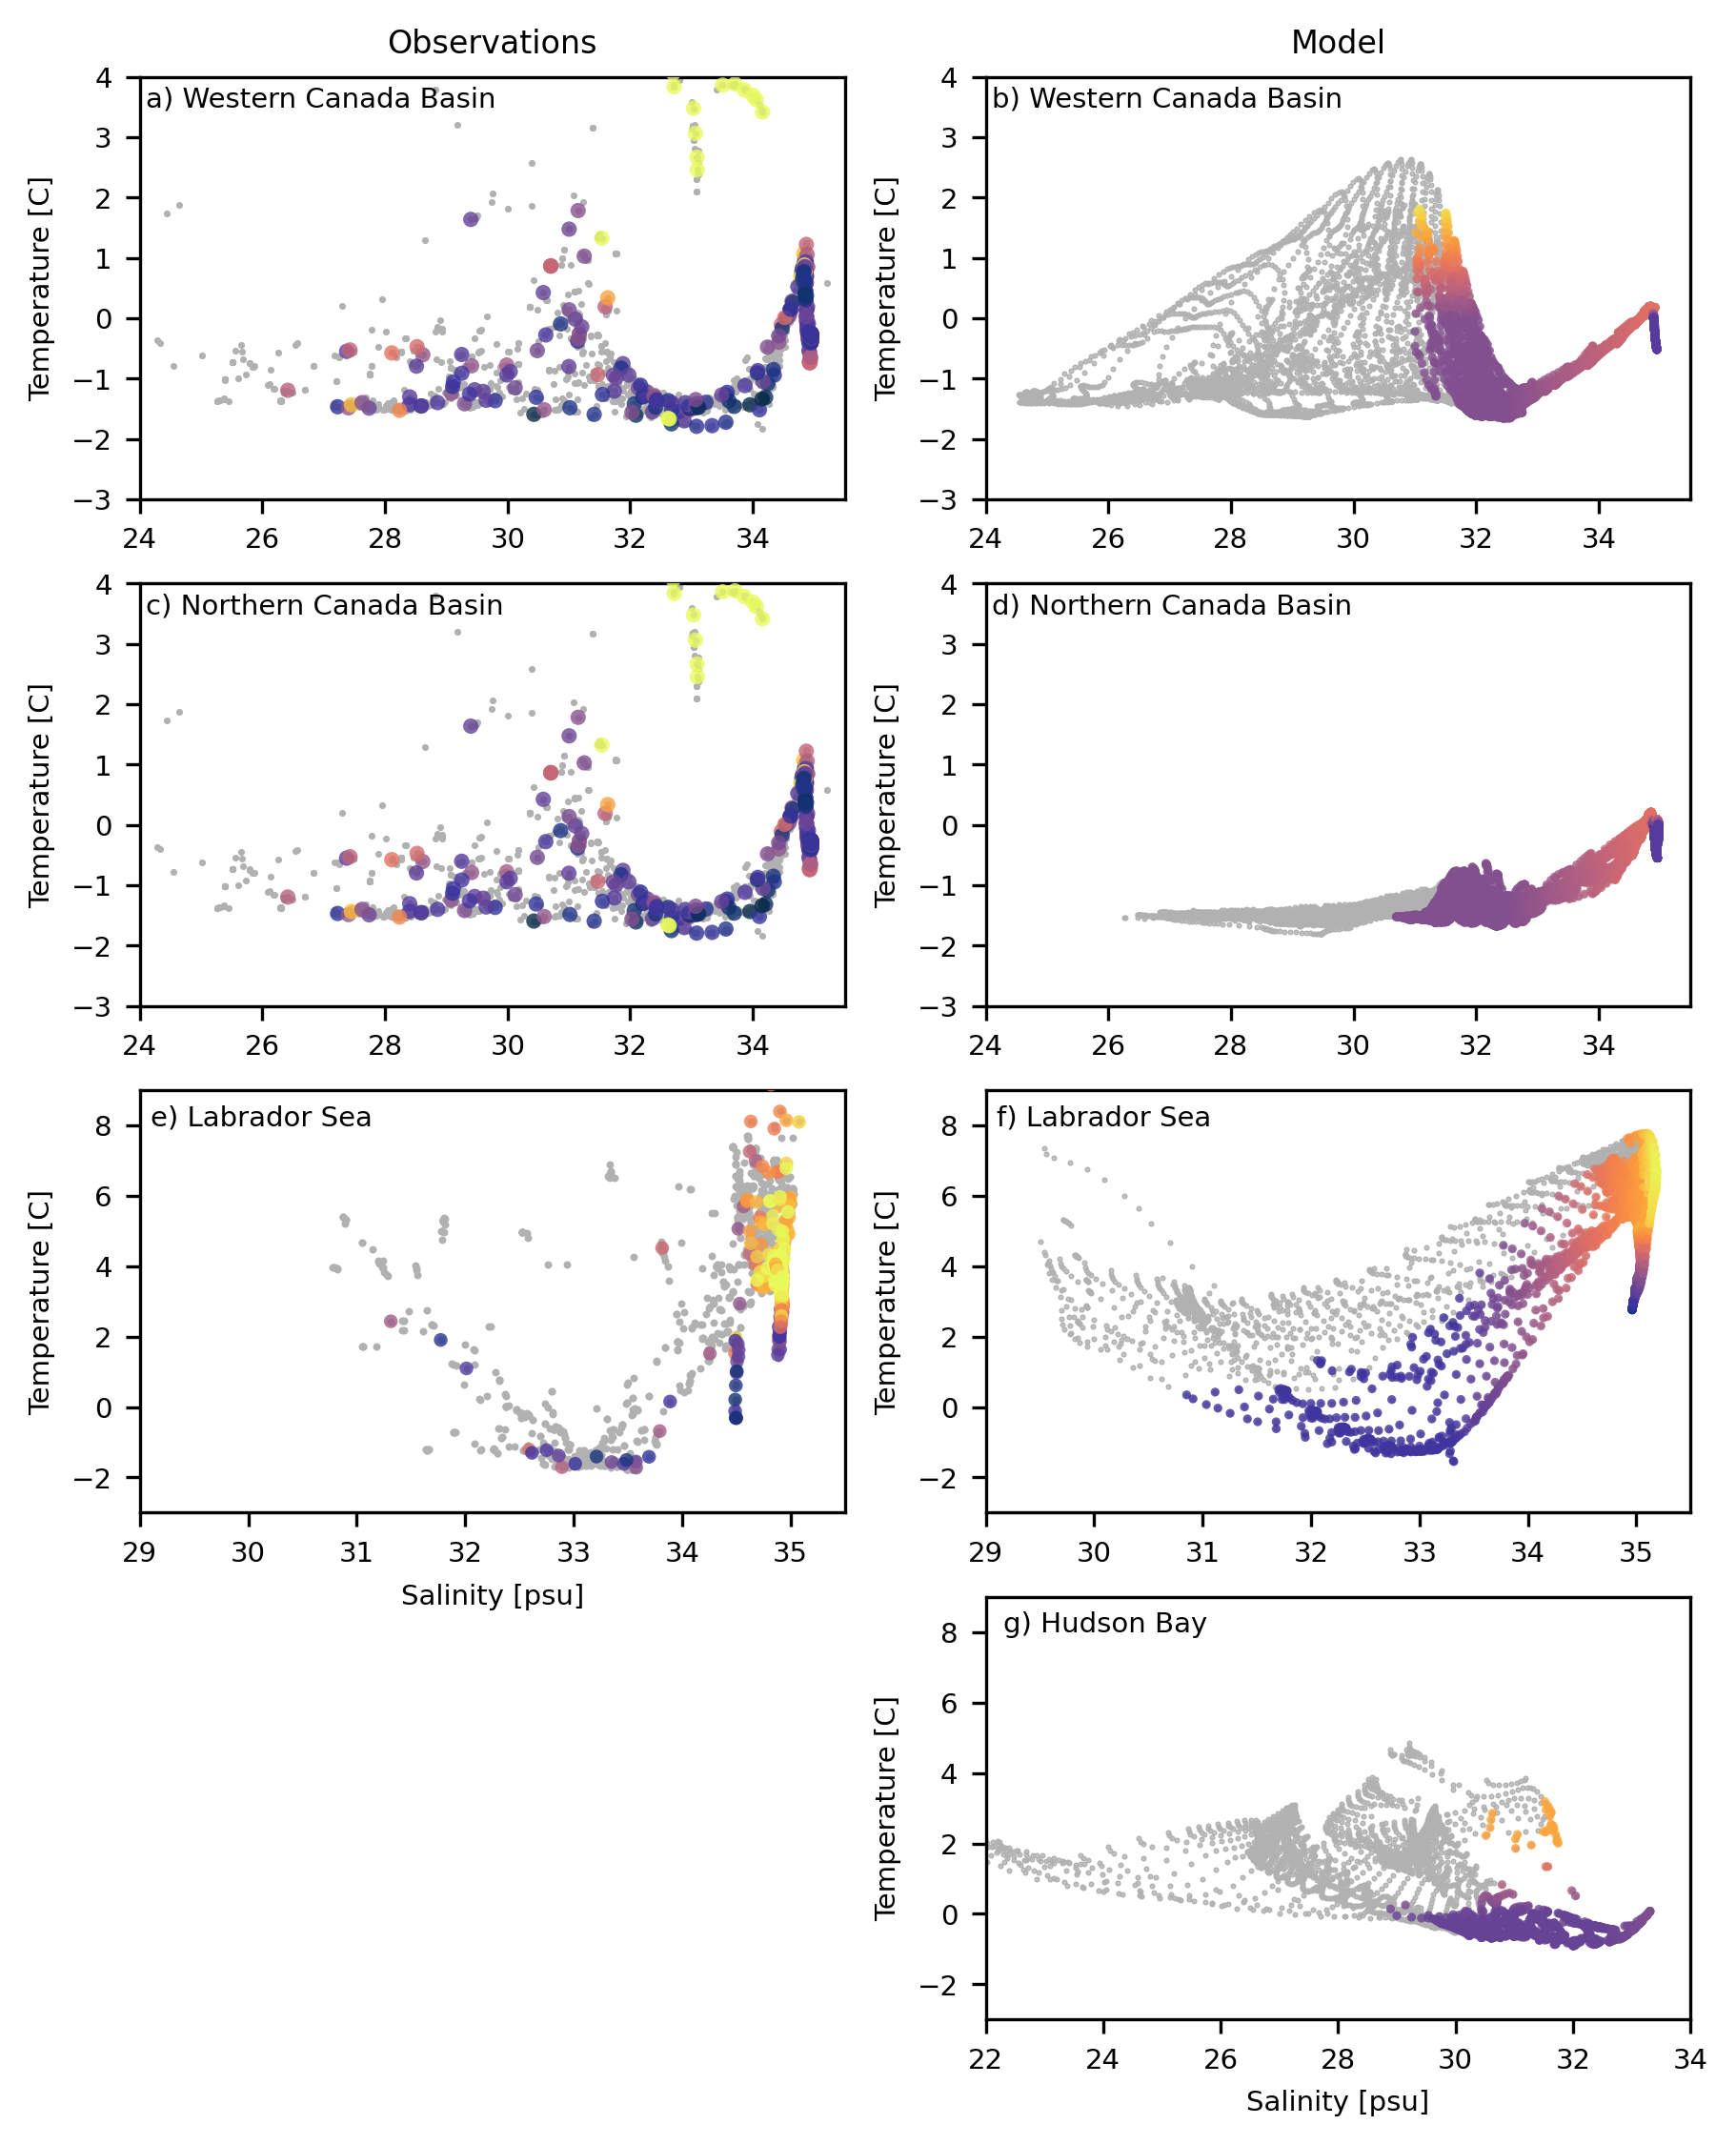

In [104]:
cmap_Pb = cmocean.cm.thermal
vmin_AO = 0; vmax_AO = 8;
vmin_LS = 0; vmax_LS = 30;

fig, ax = plt.subplots(4,2, figsize=(7.0,9), dpi=300)

for n,axis in enumerate(ax.ravel()):
    axis.tick_params(axis='both', labelsize=7)
    axis.set_xlim(24, 35.5)
    if n < 4:
        axis.set_ylim(-3, 4)
    else:
        axis.set_ylim(-3, 9)
    axis.set_ylabel('Temperature [C]', fontsize=7)
#     if n!=6:
#         plot_density_lines(axis)
        
ax[2,0].set_xlabel('Salinity [psu]', fontsize=7)
ax[3,1].set_xlabel('Salinity [psu]', fontsize=7)
ax[0,0].set_title('Observations', fontsize=8)
ax[0,1].set_title('Model', fontsize=8)

ax[0,0].text(24.1, 3.5, 'a) Western Canada Basin', fontsize=7);
ax[0,1].text(24.1, 3.5, 'b) Western Canada Basin', fontsize=7);
ax[1,0].text(24.1, 3.5, 'c) Northern Canada Basin', fontsize=7);
ax[1,1].text(24.1, 3.5, 'd) Northern Canada Basin', fontsize=7);
ax[2,0].text(29.1, 8, 'e) Labrador Sea', fontsize=7);
ax[2,1].text(29.1, 8, 'f) Labrador Sea', fontsize=7);
ax[3,0].axis('off')
ax[2,0].set_xlim(29,35.5)
ax[2,1].set_xlim(29,35.5)
ax[3,1].set_xlim(22,34)
ax[3,1].text(22.3, 8, 'g) Hudson Bay', fontsize=7);

#----- Observations: ----------------------------------------------------
ax[0,0].scatter(AO_sal_pss78.flatten(), AO_temp_C.flatten(), c=light_gray, s=0.5, zorder=2, alpha=1)
ax[0,0].scatter(AO_sal_pss78.flatten(), AO_temp_C.flatten(), c=AO_dPb_pmolL, \
           alpha=0.8, s=15, edgecolor='k', linewidth=0.0, zorder=3, vmin=vmin_AO, vmax=vmax_AO, cmap=cmap_Pb)

ax[1,0].scatter(AO_sal_pss78.flatten(), AO_temp_C.flatten(), c=light_gray, s=0.5, zorder=2, alpha=1)
ax[1,0].scatter(AO_sal_pss78.flatten(), AO_temp_C.flatten(), c=AO_dPb_pmolL, \
           alpha=0.8, s=15, edgecolor='k', linewidth=0.0, zorder=3, vmin=vmin_AO, vmax=vmax_AO, cmap=cmap_Pb)


ax[2,0].scatter(Sbdy_sal_pss78.flatten(), Sbdy_temp_C.flatten(), c=light_gray, s=0.8, zorder=2, alpha=1)
ax[2,0].scatter(Sbdy_sal_pss78.flatten(), Sbdy_temp_C.flatten(), c=Sbdy_dPb_pmolL, \
           alpha=0.8, s=12, edgecolor='k', linewidth=0.0, zorder=3, vmin=vmin_LS, vmax=vmax_LS, cmap=cmap_Pb)

#----- Model: -----------------------------------------------------------
layer  = 0
top    = 15
ax[0,1].scatter(wCB_S[:,layer,:], wCB_T[:,layer,:], c=light_gray, s=0.2, zorder=1, alpha=1)
ax[1,1].scatter(nCB_S[:,:,layer], nCB_T[:,:,layer], c=light_gray, s=0.2, zorder=1, alpha=1)
ax[2,1].scatter(LS_S[:,layer,:] , LS_T[:,layer,:] , c=light_gray, s=0.2, zorder=1, alpha=1)
ax[3,1].scatter(HB_S[:,:,layer] , HB_T[:,:,layer] , c=light_gray, s=0.2, zorder=1, alpha=1)

ax[0,1].scatter(wCB_S[top:,layer,:], wCB_T[top:,layer,:], c=dPb_wCB[top:,layer,:]*1e12, \
                alpha=0.8, s=5, edgecolor='k', linewidth=0.0, zorder=2, vmin=vmin_AO, vmax=vmax_AO, cmap=cmap_Pb)
ax[1,1].scatter(nCB_S[top:,:,layer], nCB_T[top:,:,layer], c=dPb_nCB[top:,:,layer]*1e12, \
                alpha=0.8, s=5, edgecolor='k', linewidth=0.0, zorder=2, vmin=vmin_AO, vmax=vmax_AO, cmap=cmap_Pb)
ax[2,1].scatter(LS_S[top:,layer,:] , LS_T[top:,layer,:] , c=dPb_LS[top:,layer,:]*1e12, \
                alpha=0.8, s=5, edgecolor='k', linewidth=0.0, zorder=2, vmin=vmin_LS, vmax=vmax_LS, cmap=cmap_Pb)
ax[3,1].scatter(HB_S[top:,:,layer], HB_T[top:,:,layer], c=dPb_HB[top:,:,layer]*1e12, \
                alpha=0.8, s=5, edgecolor='k', linewidth=0.0, zorder=2, vmin=0, vmax=10, cmap=cmap_Pb)

# cbaxes = fig.add_axes([0.15, 0.15, 0.02, 0.22]);
# CBar   = plt.colorbar(CB1, ax=ax, cax=cbaxes); 
# CBar.set_label('Dissolved Pb [pM]', fontsize=7)
# CBar.ax.tick_params(axis='y', length=0, labelsize=7)

# cbaxes = fig.add_axes([0.15, 0.15, 0.02, 0.22]);
# CBar   = plt.colorbar(CB1, ax=ax, cax=cbaxes); 
# CBar.set_label('Dissolved Pb [pM]', fontsize=7)
# CBar.ax.tick_params(axis='y', length=0, labelsize=7)
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_explorations/TS_observations_LS.jpg', dpi=300, bbox_inches='tight')